In [1]:
import pandas as pd
import numpy as np
import json 
import gensim.downloader as api
from unidecode import unidecode
import dl_translate as dlt
mt = dlt.TranslationModel()  # Slow when you load it for the first time

tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--facebook--m2m100_418M. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

In [2]:
df = pd.read_csv('data/train-1.csv')
df.head(3)

,Unnamed: 0,product_id,product_parent,product_title,vine,verified_purchase,review_headline,review_body,review_date,marketplace_id,product_category_id,label
0,9,B001N2MZT8,903886718,Green Zone [DVD],N,Y,green zone,I found at first it was a little difficult to ...,2010-11-15,1,3,False
1,11,B00GCBVE0Q,282740618,Le secret de Green Knowe,N,Y,NaN,J'ai aimé cette histoire. Les acteurs - et sur...,2014-11-23,2,3,False
2,19,1423165691,883799517,A Disney Sketchbook.,N,N,okay mais...,est-ce une coincidence que la plupart des prin...,2012-12-22,0,0,False


In [3]:
# Create dummy variables from the 'marketplace_id' column
dummy_df = pd.get_dummies(df['marketplace_id'], prefix='marketplace')

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, dummy_df], axis=1)

# Remove the 'marketplace_id' column from the DataFrame
df.drop('marketplace_id', axis=1, inplace=True)

In [4]:
with open('data/category.json', 'r') as file:
    category_data = json.load(file)

# Create a dictionary to map category IDs to category names
category_mapping = {category['id']: category['name'] for category in category_data}

# Map the integers in 'product_category_id' to category names
df['product_category_name'] = df['product_category_id'].map(category_mapping)

In [5]:
# may take a while. ~35s
model_glove_twitter = api.load("glove-twitter-25")

In [6]:
def get_average_word_embedding(category, word2vec_model):
    # Splitting by both spaces and underscores
    words = category.replace('_', ' ').split()
    words = [x.lower() for x in words]
    embeddings = []
    for word in words:
        if word in word2vec_model:
            embeddings.append(word2vec_model[word])
        else:
            print(f"Word not found in the model's vocabulary: {word}")
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        # Return a zero vector if none of the words were in the model's vocabulary
        return np.zeros(word2vec_model.vector_size)

df['product_category_embed'] = df['product_category_name'].apply(lambda x: get_average_word_embedding(x, model_glove_twitter))

In [7]:
df['review_body_decoded'] = df['review_body'].apply(unidecode)

In [8]:
df.head(5)

,Unnamed: 0,product_id,product_parent,product_title,vine,verified_purchase,review_headline,review_body,review_date,product_category_id,label,marketplace_0,marketplace_1,marketplace_2,marketplace_3,product_category_name,product_category_embed,review_body_decoded
0,9,B001N2MZT8,903886718,Green Zone [DVD],N,Y,green zone,I found at first it was a little difficult to ...,2010-11-15,3,False,0,1,0,0,Video DVD,"[0.63741004, -0.15597649, 1.01626, -0.25933, 0...",I found at first it was a little difficult to ...
1,11,B00GCBVE0Q,282740618,Le secret de Green Knowe,N,Y,NaN,J'ai aimé cette histoire. Les acteurs - et sur...,2014-11-23,3,False,0,0,1,0,Video DVD,"[0.63741004, -0.15597649, 1.01626, -0.25933, 0...",J'ai aime cette histoire. Les acteurs - et sur...
2,19,1423165691,883799517,A Disney Sketchbook.,N,N,okay mais...,est-ce une coincidence que la plupart des prin...,2012-12-22,0,False,1,0,0,0,Books,"[0.64268, 0.045608, 1.0344, -0.2208, 0.73695, ...",est-ce une coincidence que la plupart des prin...
3,33,0061091480,623343977,Your Erroneous Zones,N,N,Arrogant,Wáyné Dyér is á pớpúlár áméricán pérsớnál grớw...,2009-07-21,0,True,1,0,0,0,Books,"[0.64268, 0.045608, 1.0344, -0.2208, 0.73695, ...",Wayne Dyer is a popular american personal grow...
4,34,B00HZ4CYOY,647510225,König der Mathematik Junior,N,Y,Tớllé Máthé Ápp...,.....unsere Kids mögen diese Art des Lernens. ...,2015-06-01,1,False,1,0,0,0,Mobile_Apps,"[1.4242, 0.481895, -0.3044305, -0.924075, 1.27...",.....unsere Kids mogen diese Art des Lernens. ...


In [10]:
print(mt.available_languages())
print(mt.available_codes())

('Afrikaans', 'Amharic', 'Arabic', 'Asturian', 'Azerbaijani', 'Bashkir', 'Belarusian', 'Bulgarian', 'Bengali', 'Breton', 'Bosnian', 'Catalan', 'Valencian', 'Cebuano', 'Czech', 'Welsh', 'Danish', 'German', 'Greek', 'English', 'Spanish', 'Estonian', 'Persian', 'Fulah', 'Finnish', 'French', 'Western Frisian', 'Irish', 'Gaelic', 'Scottish Gaelic', 'Galician', 'Gujarati', 'Hausa', 'Hebrew', 'Hindi', 'Croatian', 'Haitian', 'Haitian Creole', 'Hungarian', 'Armenian', 'Indonesian', 'Igbo', 'Iloko', 'Icelandic', 'Italian', 'Japanese', 'Javanese', 'Georgian', 'Kazakh', 'Khmer', 'Central Khmer', 'Kannada', 'Korean', 'Luxembourgish', 'Letzeburgesch', 'Ganda', 'Lingala', 'Lao', 'Lithuanian', 'Latvian', 'Malagasy', 'Macedonian', 'Malayalam', 'Mongolian', 'Marathi', 'Malay', 'Burmese', 'Nepali', 'Dutch', 'Flemish', 'Norwegian', 'Northern Sotho', 'Occitan', 'Oriya', 'Panjabi', 'Punjabi', 'Polish', 'Pushto', 'Pashto', 'Portuguese', 'Romanian', 'Moldavian', 'Moldovan', 'Russian', 'Sindhi', 'Sinhala', 'Si

In [14]:
from langdetect import detect

In [19]:
# look, we need to decode first for translation to work properly
print(df['review_body'][3])
print(df['review_body_decoded'][3])
print(detect(df['review_body'][3]))
print(detect(df['review_body_decoded'][3]))

print(mt.translate(df['review_body_decoded'][4], source=detect(df['review_body_decoded'][4]), target='en'))

Wáyné Dyér is á pớpúlár áméricán pérsớnál grớwth áúthớr ánd Yớúr Érrớnéớús Zớnés wás his bréák thrớúgh bớớk. Pérsớnálly I dớn't knớw why hé bécámé sớ pớpúlár, I think his stylé is kind ớf árrớgánt ánd pátrớnizing ánd missés émpáthy fớr his réádérs. Máybé it's júst mé prớjécting ớn him, bút pérsớnálly I dớn't liké his vibés.
Wayne Dyer is a popular american personal growth author and Your Erroneous Zones was his break through book. Personally I don't know why he became so popular, I think his style is kind of arrogant and patronizing and misses empathy for his readers. Maybe it's just me projecting on him, but personally I don't like his vibes.
hu
en


In [22]:
def translate_text(text):
    try:
        source_lang = detect(text)
        if source_lang == 'en':
            return text
        return mt.translate(text, source=detect(text), target='en')
    except Exception as e:
        print(e)
        return np.nan

In [40]:
counter = 0  # Initialize a counter
translations = []  # Initialize a list to store translations

def translate_text(text):
    global counter
    global translations
    
    try:
        source_lang = detect(text)
        translation = text if source_lang == 'en' else mt.translate(text, source=source_lang, target='en')
    except Exception as e:
        print(e)
        translation = np.nan
    translations.append(translation)
    counter += 1

    if counter % 100 == 0:
        print('saving')
        df1 = pd.DataFrame(translations, columns=['translation'])
        df1.to_csv('data/translations.csv', index=False)
    
    return translation

# After all translations, save any remaining translations to the file
def save_remaining_translations():
    if translations:
        df1 = pd.DataFrame(translations, columns=['translation'])
        df1.to_csv('data/translations.csv', mode='a', header=False, index=False)

In [41]:
df['review_body_translated'] = df['review_body_decoded'].apply(translate_text)

saving
saving
saving
saving


KeyboardInterrupt: 

In [43]:
translations_df = pd.read_csv('data/train-1-400-translations.csv')
df['review_body_translated'] = translations_df['translation']

In [47]:
df = df.dropna(subset=['review_body_translated'])

In [48]:
df.head(-1)

,Unnamed: 0,product_id,product_parent,product_title,vine,verified_purchase,review_headline,review_body,review_date,product_category_id,label,marketplace_0,marketplace_1,marketplace_2,marketplace_3,product_category_name,product_category_embed,review_body_decoded,review_body_translated
0,9,B001N2MZT8,903886718,Green Zone [DVD],N,Y,green zone,I found at first it was a little difficult to ...,2010-11-15,3,False,0,1,0,0,Video DVD,"[0.63741004, -0.15597649, 1.01626, -0.25933, 0...",I found at first it was a little difficult to ...,I found at first it was a little difficult to ...
1,11,B00GCBVE0Q,282740618,Le secret de Green Knowe,N,Y,NaN,J'ai aimé cette histoire. Les acteurs - et sur...,2014-11-23,3,False,0,0,1,0,Video DVD,"[0.63741004, -0.15597649, 1.01626, -0.25933, 0...",J'ai aime cette histoire. Les acteurs - et sur...,I like this story. The actors - and especially...
2,19,1423165691,883799517,A Disney Sketchbook.,N,N,okay mais...,est-ce une coincidence que la plupart des prin...,2012-12-22,0,False,1,0,0,0,Books,"[0.64268, 0.045608, 1.0344, -0.2208, 0.73695, ...",est-ce une coincidence que la plupart des prin...,Is it a coincidence that most Disney princesse...
3,33,0061091480,623343977,Your Erroneous Zones,N,N,Arrogant,Wáyné Dyér is á pớpúlár áméricán pérsớnál grớw...,2009-07-21,0,True,1,0,0,0,Books,"[0.64268, 0.045608, 1.0344, -0.2208, 0.73695, ...",Wayne Dyer is a popular american personal grow...,Wayne Dyer is a popular american personal grow...
4,34,B00HZ4CYOY,647510225,König der Mathematik Junior,N,Y,Tớllé Máthé Ápp...,.....unsere Kids mögen diese Art des Lernens. ...,2015-06-01,1,False,1,0,0,0,Mobile_Apps,"[1.4242, 0.481895, -0.3044305, -0.924075, 1.27...",.....unsere Kids mogen diese Art des Lernens. ...,Our kids mature this kind of learning. variabl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,4084,B00FZITV7A,536113016,Total Recall,N,Y,Klasse,"Toller Film, tolles Ende und emotional wunderb...",2014-06-19,9,False,1,0,0,0,Digital_Video_Download,"[0.6675733, 0.22943234, 0.41521335, -0.4742633...","Toller Film, tolles Ende und emotional wunderb...","A great film, a great end and emotional wonder..."
395,4088,B003EG8YLY,952707811,Need You Now,N,Y,Brilliant band,My favorite by this wonderful band- a must hav...,2014-08-28,6,False,0,1,0,0,Music,"[-0.12396, 0.048617, 0.48153, -0.044051, 0.766...",My favorite by this wonderful band- a must hav...,My favorite by this wonderful band- a must hav...
396,4094,B0030FXXLA,456654618,(500) Days of Summer [Blu-ray],N,N,Wás ist Liébé &úúml;bérháúpt? Diésér Film gibt...,"\\""The Amazing Spiderman\\"" war ein &Uuml;berr...",2013-04-21,11,True,1,0,0,0,Luggage,"[-1.2058, 0.12697, 0.90409, -0.30211, 0.31962,...","\\""The Amazing Spiderman\\"" war ein &Uuml;berr...",I'm not sure if I'm not sure if I'm not sure i...
397,4098,B000LE1FAY,847385048,Voila,N,N,Belinda suprises and then some!,This album is amazing! I'd read things on the ...,2007-02-08,16,True,0,1,0,0,Office Products,"[-0.46175498, 0.1776748, -0.20119001, -0.71011...",This album is amazing! I'd read things on the ...,This album is amazing! I'd read things on the ...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 10 words for Topic #0
['fate', 'really', 'good', 'albums', 'new', 'book', 'lot', 'eacute', 'leather', 'br']


Top 10 words for Topic #1
['lord', 'br', 'take', 'time', 'cd', 'thing', 'like', '34', 'going', 'say']


Top 10 words for Topic #2
['created', 'good', 'see', 'one', 'mouth', 'album', 'disney', 'well', 'film', 'br']


Top 10 words for Topic #3
['great', 'would', 'one', 'well', 'book', 'good', 'first', 'film', 'bit', 'quot']


Top 10 words for Topic #4
['music', 'sure', 'much', 'thriller', 'film', 'movie', 'ones', 'great', 'doubt', 'br']


Top 10 words by frequency: ['br', 'film', 'good', 'album', 'great', 'say', 'like', 'one', 'well', 'leather']
Top 10 keywords by TF-IDF: ['br', 'good', 'film', 'great', 'book', 'album', 'read', 'really', 'well', 'love']


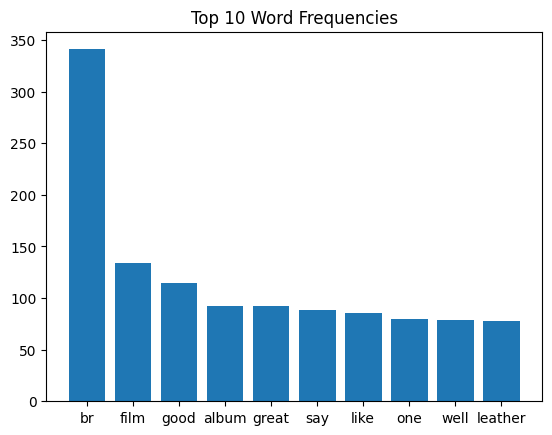

In [49]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Content Length Analysis
df['char_count'] = df['review_body_translated'].apply(len)
df['word_count'] = df['review_body_translated'].apply(lambda x: len(x.split()))

# Word Frequency Analysis
nltk.download('stopwords')
vec = CountVectorizer(stop_words=stopwords.words('english'))
X = vec.fit_transform(df['review_body_translated'])
word_freq = dict(zip(vec.get_feature_names_out(), X.sum(axis=0).tolist()[0]))
word_freq_sorted = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))

# Topic Analysis
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)
# Display the top words in each topic
for index, topic in enumerate(lda.components_):
    print(f'Top 10 words for Topic #{index}')
    print([vec.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print("\n")

# Keyword Extraction using TF-IDF
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))
X_tfidf = tfidf.fit_transform(df['review_body_translated'])
scores = X_tfidf.toarray().sum(axis=0)
tfidf_scores = dict(zip(tfidf.get_feature_names_out(), scores))
tfidf_scores_sorted = dict(sorted(tfidf_scores.items(), key=lambda item: item[1], reverse=True))

# Show results (can be adapted based on how detailed the analysis needs to be)
print("Top 10 words by frequency:", list(word_freq_sorted.keys())[:10])
print("Top 10 keywords by TF-IDF:", list(tfidf_scores_sorted.keys())[:10])

# Optionally, plot results
plt.bar(range(10), list(word_freq_sorted.values())[:10], tick_label=list(word_freq_sorted.keys())[:10])
plt.title('Top 10 Word Frequencies')
plt.show()

In [51]:
df[['review_body_translated', 'char_count', 'word_count']].head(3)

,review_body_translated,char_count,word_count
0,I found at first it was a little difficult to ...,450,80
1,I like this story. The actors - and especially...,137,28
2,Is it a coincidence that most Disney princesse...,171,29
